In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import pathlib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

1.1:
Loading the data and setting initial variables. The data is reviews from yelp and the sentiment within them from: https://www.tensorflow.org/datasets/catalog/yelp_polarity_reviews. The model will attempt to predict sentiment of a review by looking at the words used in combination with each other. The RNN is useful here because they tend to be good at sequneces of data that show patterns, and text recognition like what this model will be doing is a kind of pattern. The RNN benefits from being passed information from previous steps because it is better able to learn the patterns.

In [2]:
BATCH_SIZE = 64
dataset, info = tfds.load('yelp_polarity_reviews', with_info=True, as_supervised=True)
train_dataset, val_dataset = dataset['train'], dataset['test']
test_dataset = train_dataset.take(320)
train_dataset = train_dataset.skip(320)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

The text must be converted from text to numeric because the RNN must have numerical values, not strings or characters

In [3]:
text_to_numeric = tf.keras.layers.TextVectorization(max_tokens=1000)
text_to_numeric.adapt(train_dataset.map(lambda text, label: text))

Here is a little visualization of what the data looks like. This is an example of a negative review, denoted by the zero label, with the text and numeric representation. The numeric representation is zero paded.

In [4]:
for example, label in train_dataset.take(1):
    print('text: ', example.numpy()[:1])
    print('numeric: ', text_to_numeric(example)[:1].numpy())
    print('label: ',label[0])

text:  [b"I come to this pharmacy often, not by choice. The prescription for my son can only be filled here if I want my insurance to pay for it. So every other week I'm forced to reserve time I don't really have available to go stand in a long line to deal with stupid employees that can never seem to get anything right and to top it off they all have attitudes.\\nTheir prices are high and the employees are rude. The only good thing about this place is the cleanliness... its always clean and organized."]
numeric:  [[  4 121   5  16   1 657  22  77 647   2   1  10  14   1  76  69  29 829
   45  38   4 132  14   1   5 273  10   9  27 186  80 404  85   1   5   1
   49   4  73  62  23 650   5  59 837  11   6 188 263   5 422  17   1 560
   13  76  87 536   5  43 245 145   3   5 276   9 110  19  39  23   1 252
   28 358   3   2 560  28 398   2  69  35 181  56  16  31  12   2   1  47
  123 288   3   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   

Here the model is set. First the text is converted to numeric representation, then the embedding layer converts the words to vectors which can be trained. 

For the RNN, I decided to set the activation funtion to tanh becuase I found it to perform well through experimentation, though admittidly there seems only be a small amount of varience between most functions. This part also makes use of the bidirectional wrapper which propogates the input forward and backward, which improved results.

The final two dense layers convert the output to a single classification, I decided to use relu here after some testing. An optimizer is also included in the compile, which has a fairly large positive effect.

In [5]:
model = tf.keras.Sequential([
    text_to_numeric,
    tf.keras.layers.Embedding(
        input_dim=len(text_to_numeric.get_vocabulary()),
        output_dim=BATCH_SIZE,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(BATCH_SIZE, activation='tanh')),
    tf.keras.layers.Dense(BATCH_SIZE, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Here we fit the model, I found 5 epochs to be enough. While the result would probably still continue to improve a bit beyond this point it is already pretty accurate and takes a little over an hour for each epoch so further training is not worth it.

In [6]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=val_dataset,
                    validation_steps=30)

Epoch 1/5
8745/8745 [==============================] - 4464s 510ms/step - loss: 0.2693 - accuracy: 0.8792 - val_loss: 0.2070 - val_accuracy: 0.9135
Epoch 2/5
8745/8745 [==============================] - 4237s 484ms/step - loss: 0.2303 - accuracy: 0.9020 - val_loss: 0.1991 - val_accuracy: 0.9125
Epoch 3/5
8745/8745 [==============================] - 4446s 508ms/step - loss: 0.2221 - accuracy: 0.9053 - val_loss: 0.1938 - val_accuracy: 0.9156
Epoch 4/5
8745/8745 [==============================] - 4487s 513ms/step - loss: 0.2133 - accuracy: 0.9087 - val_loss: 0.1896 - val_accuracy: 0.9177
Epoch 5/5
8745/8745 [==============================] - 4402s 503ms/step - loss: 0.2073 - accuracy: 0.9109 - val_loss: 0.1883 - val_accuracy: 0.9198


Here is a graphed version of the results, accuracy corresponds to the percentage of correct guesses between positive and negative sentiments. The accuracy of the model on the training set follows closely with the accuracy on the validation set and the training results. Even after only the first epoch the results are about 88% accurate and improve slightly from there.

(0.0, 0.27336039319634436)

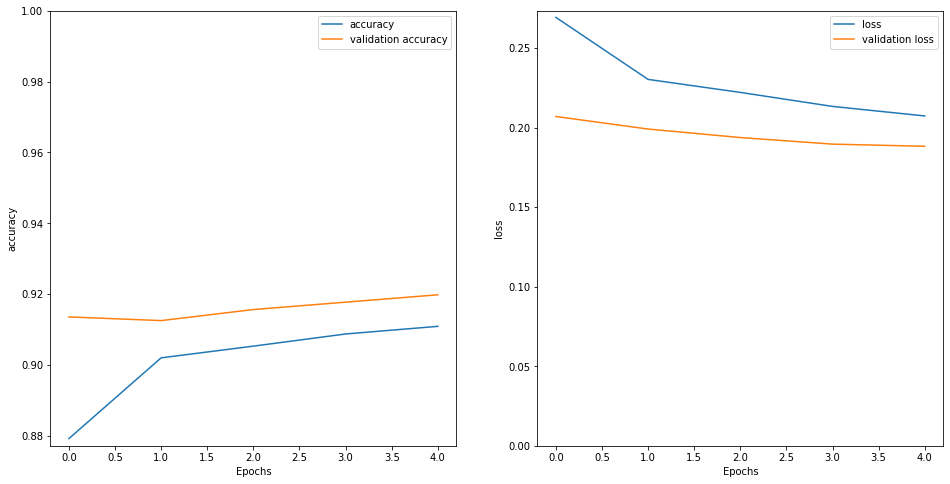

In [7]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], '')
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['accuracy', 'validation accuracy'])

plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], '')
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['loss', 'validation loss'])
plt.ylim(0, None)

Here I run a test for accuracy on the test set, which results in about 94% Accuracy. This is a little higher than the accuracy given by the model, however this set is admittedly pretty small so some variance is not unexpected. (I would make it larger but I do not have time to train the model again)

In [8]:
k = 0
labels = list(map(lambda x: x[1], test_dataset))
for i in range(5):
    for example, label in test_dataset.take(1):
        for z in range(BATCH_SIZE):
            if model.predict(example)[z] >= 0.0:
                if label[z] == 1:
                    k += 1
            else:
                if label[z] == 0:
                    k += 1
                    
print("Accuracy: " + str(k/320) + "%")

Accuracy: 0.9375%


1.2
Now we use the same model but with LSTM.

In [9]:
model = tf.keras.Sequential([
    text_to_numeric,
    tf.keras.layers.Embedding(
        input_dim=len(text_to_numeric.get_vocabulary()),
        output_dim=BATCH_SIZE,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BATCH_SIZE, activation='tanh')),
    tf.keras.layers.Dense(BATCH_SIZE, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=5,
                    validation_data=val_dataset,
                    validation_steps=30)

Epoch 1/5
8745/8745 [==============================] - 5573s 637ms/step - loss: 0.2526 - accuracy: 0.8863 - val_loss: 0.1944 - val_accuracy: 0.9156
Epoch 2/5
8745/8745 [==============================] - 5734s 656ms/step - loss: 0.2175 - accuracy: 0.9060 - val_loss: 0.1846 - val_accuracy: 0.9193
Epoch 3/5
8745/8745 [==============================] - 5013s 573ms/step - loss: 0.2050 - accuracy: 0.9114 - val_loss: 0.1671 - val_accuracy: 0.9318
Epoch 4/5
8745/8745 [==============================] - 5520s 631ms/step - loss: 0.1812 - accuracy: 0.9226 - val_loss: 0.1416 - val_accuracy: 0.9438
Epoch 5/5
8745/8745 [==============================] - 5702s 652ms/step - loss: 0.1634 - accuracy: 0.9308 - val_loss: 0.1336 - val_accuracy: 0.9474


This method produces slightly better results overall. The first epoch is already better than the first epoch of the first model, and then this one steadily improves at a higher rate. I would guess that this is because of its ability to remember over over long sequences.

It also takes about 20% longer to train each epoch, this might be because it passes more information along.

(0.0, 0.2585536062717438)

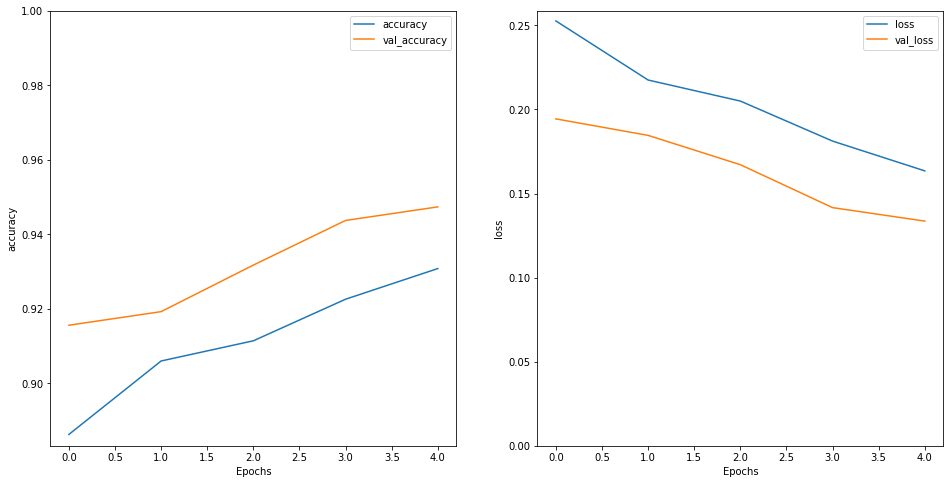

In [10]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], '')
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])

plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], '')
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.ylim(0, None)

Finally here is the last accuracy test over the test set. This data lines up with what the model predicted, showing it works pretty well.

In [12]:
k = 0
labels = list(map(lambda x: x[1], test_dataset))
for i in range(5):
    for example, label in test_dataset.take(1):
        for z in range(BATCH_SIZE):
            if model.predict(example)[z] >= 0.0:
                if label[z] == 1:
                    k += 1
            else:
                if label[z] == 0:
                    k += 1
                    
print("Accuracy: " + str(k/320) + "%")

Accuracy: 0.921875%
